In [1]:
import pandas as pd
import micropip
await micropip.install('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv('data/EDA/Groceries/Groceries_dataset.csv')
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 605.8+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

__Проведем первичный анализ и выведем основные метрики.__

In [5]:
data = df.groupby('Member_number', as_index=False)[['itemDescription']].count().rename(columns={'itemDescription': 'purchase_count'})
mean_purchases = data['purchase_count'].mean()

basic_stats = data['purchase_count'].describe()
print(f"Среднее количество покупок: {mean_purchases:.2f}")
print(f"Медиана: {data['purchase_count'].median()}")
print(f"Стандартное отклонение: {data['purchase_count'].std():.2f}")

top_customers = data.nlargest(10, 'purchase_count')
print("\nТоп-5 самых активных покупателей:")
print(top_customers)

Среднее количество покупок: 9.94
Медиана: 9.0
Стандартное отклонение: 5.31

Топ-5 самых активных покупателей:
      Member_number  purchase_count
2120           3180              36
1026           2051              33
1994           3050              33
2665           3737              33
1234           2271              31
1388           2433              31
1575           2625              31
2838           3915              31
2798           3872              30
1352           2394              29


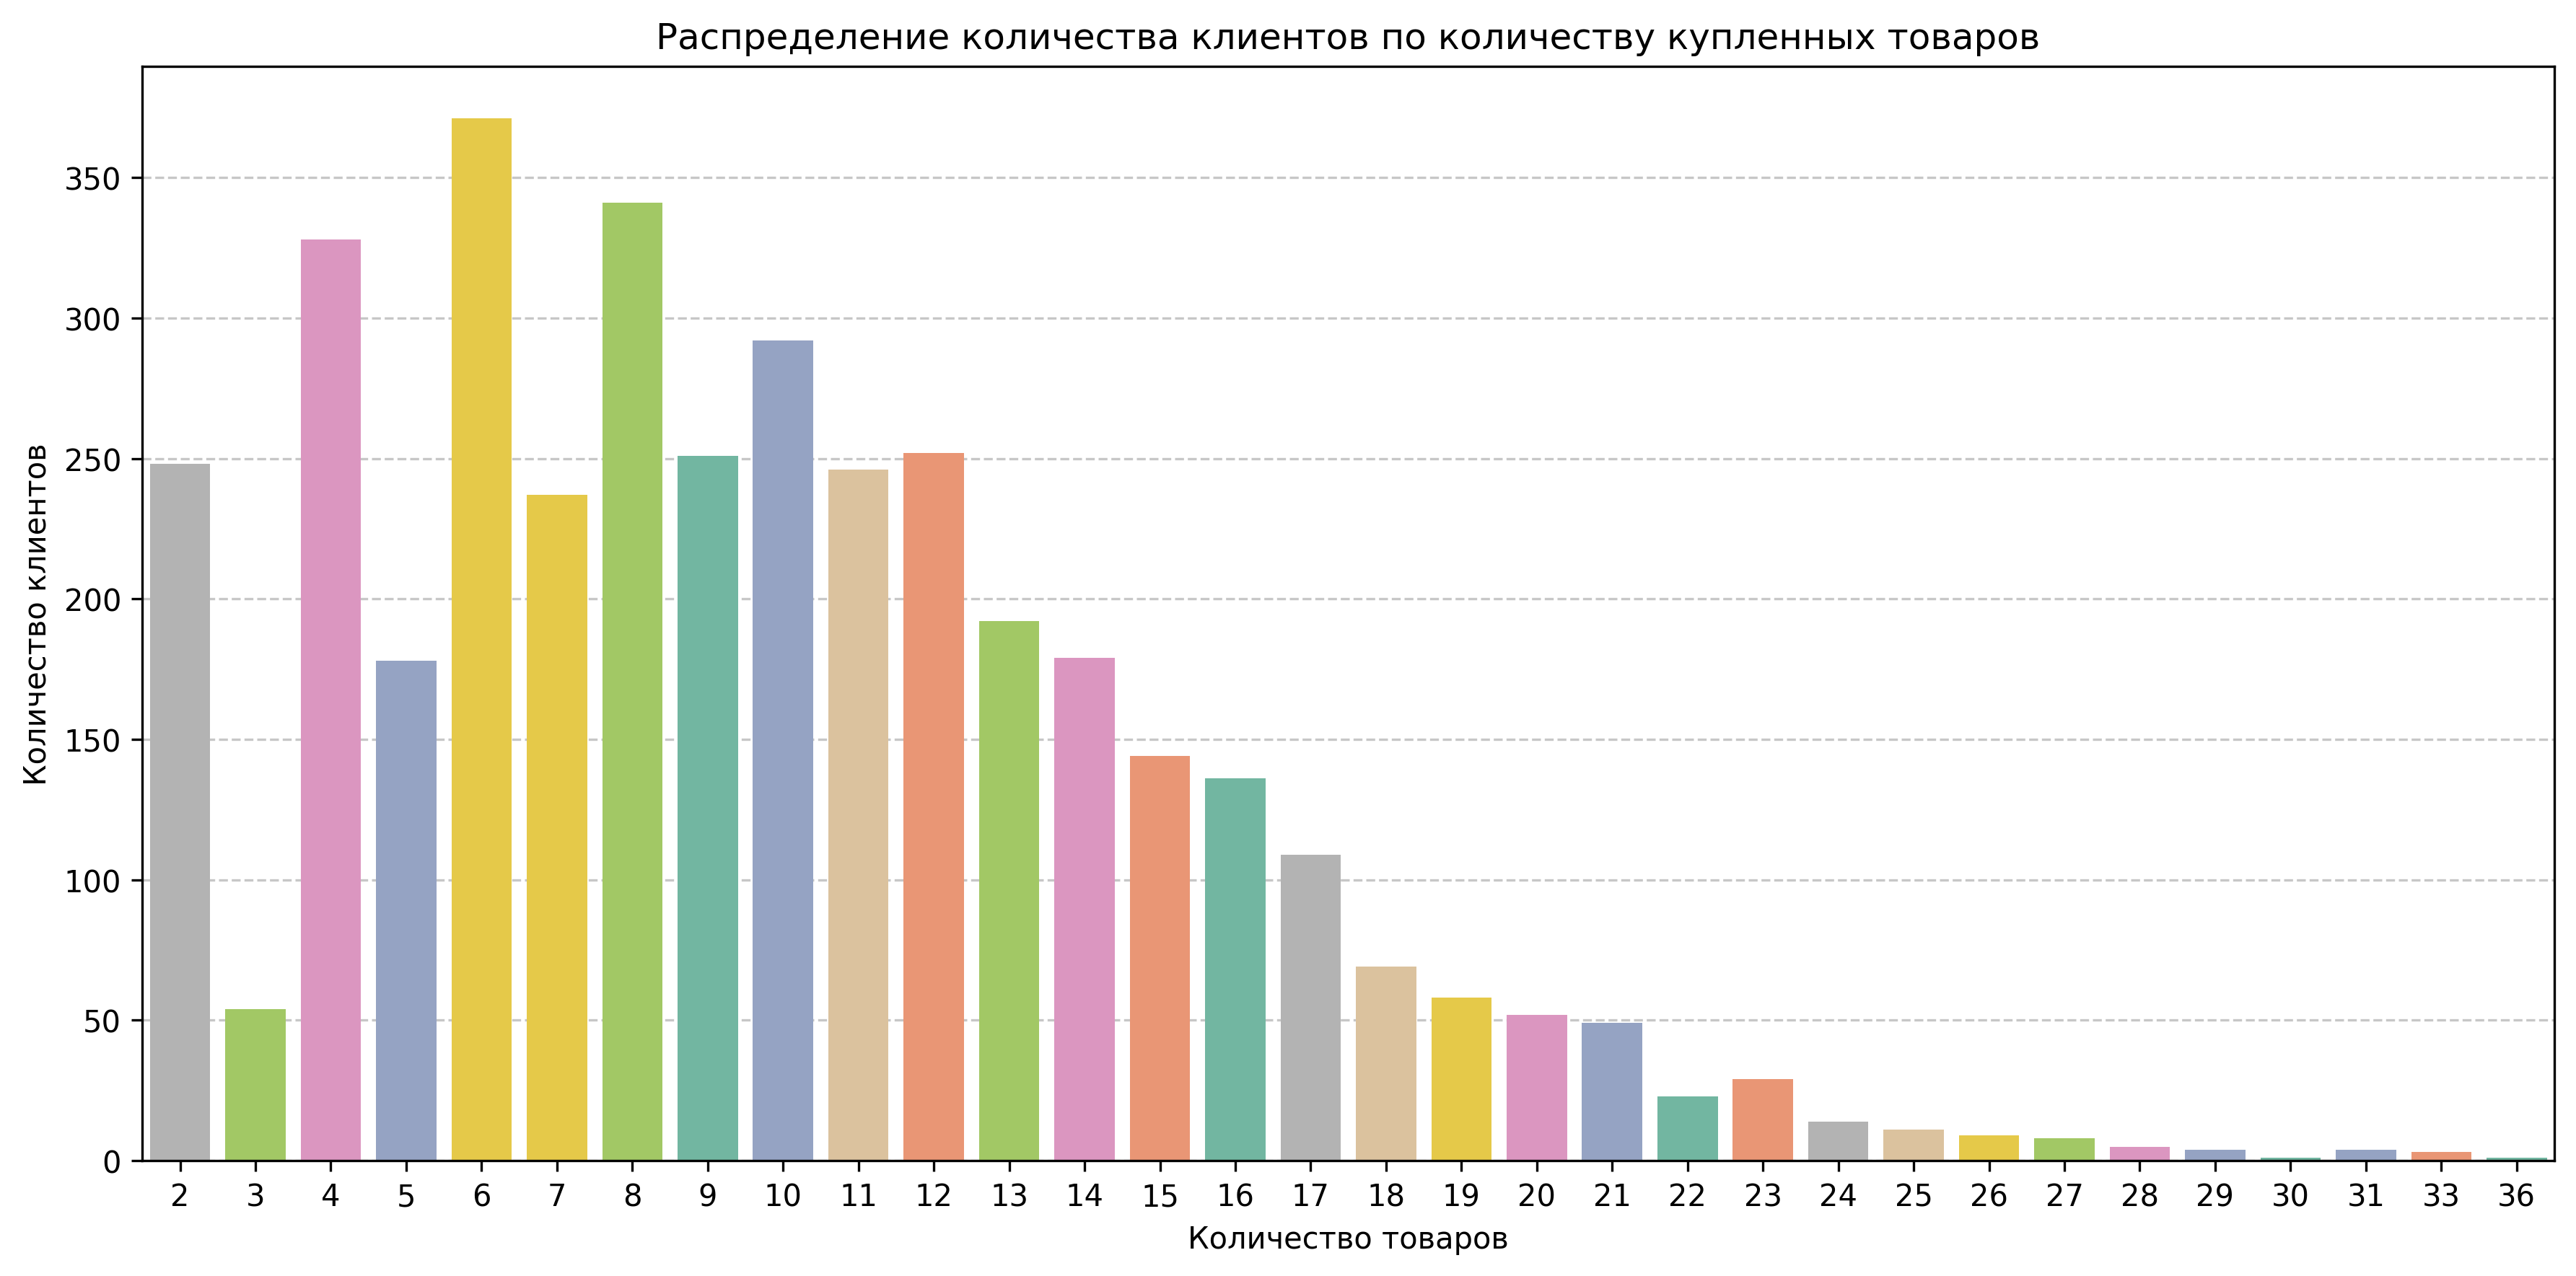

In [6]:
data = df.groupby('Member_number')[['itemDescription']].count().reset_index().rename(columns={'itemDescription': 'item_count'})
data = data.groupby('item_count')[['Member_number']].count().sort_values(by='item_count').reset_index().rename(columns={'Member_number': 'member_count'})

plt.figure(figsize=(12, 6), dpi=300)

ax = sns.barplot(
    x='item_count',
    y='member_count',
    hue='member_count',
    data=data,
    palette='Set2',
    legend=False
)

ax.set_title('Распределение количества клиентов по количеству купленных товаров')
ax.set_xlabel('Количество товаров')
ax.set_ylabel('Количество клиентов')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.show()

95-й процентиль продаж: 890
Медиана продаж: 85.0
Коэффициент вариации: 156.6%


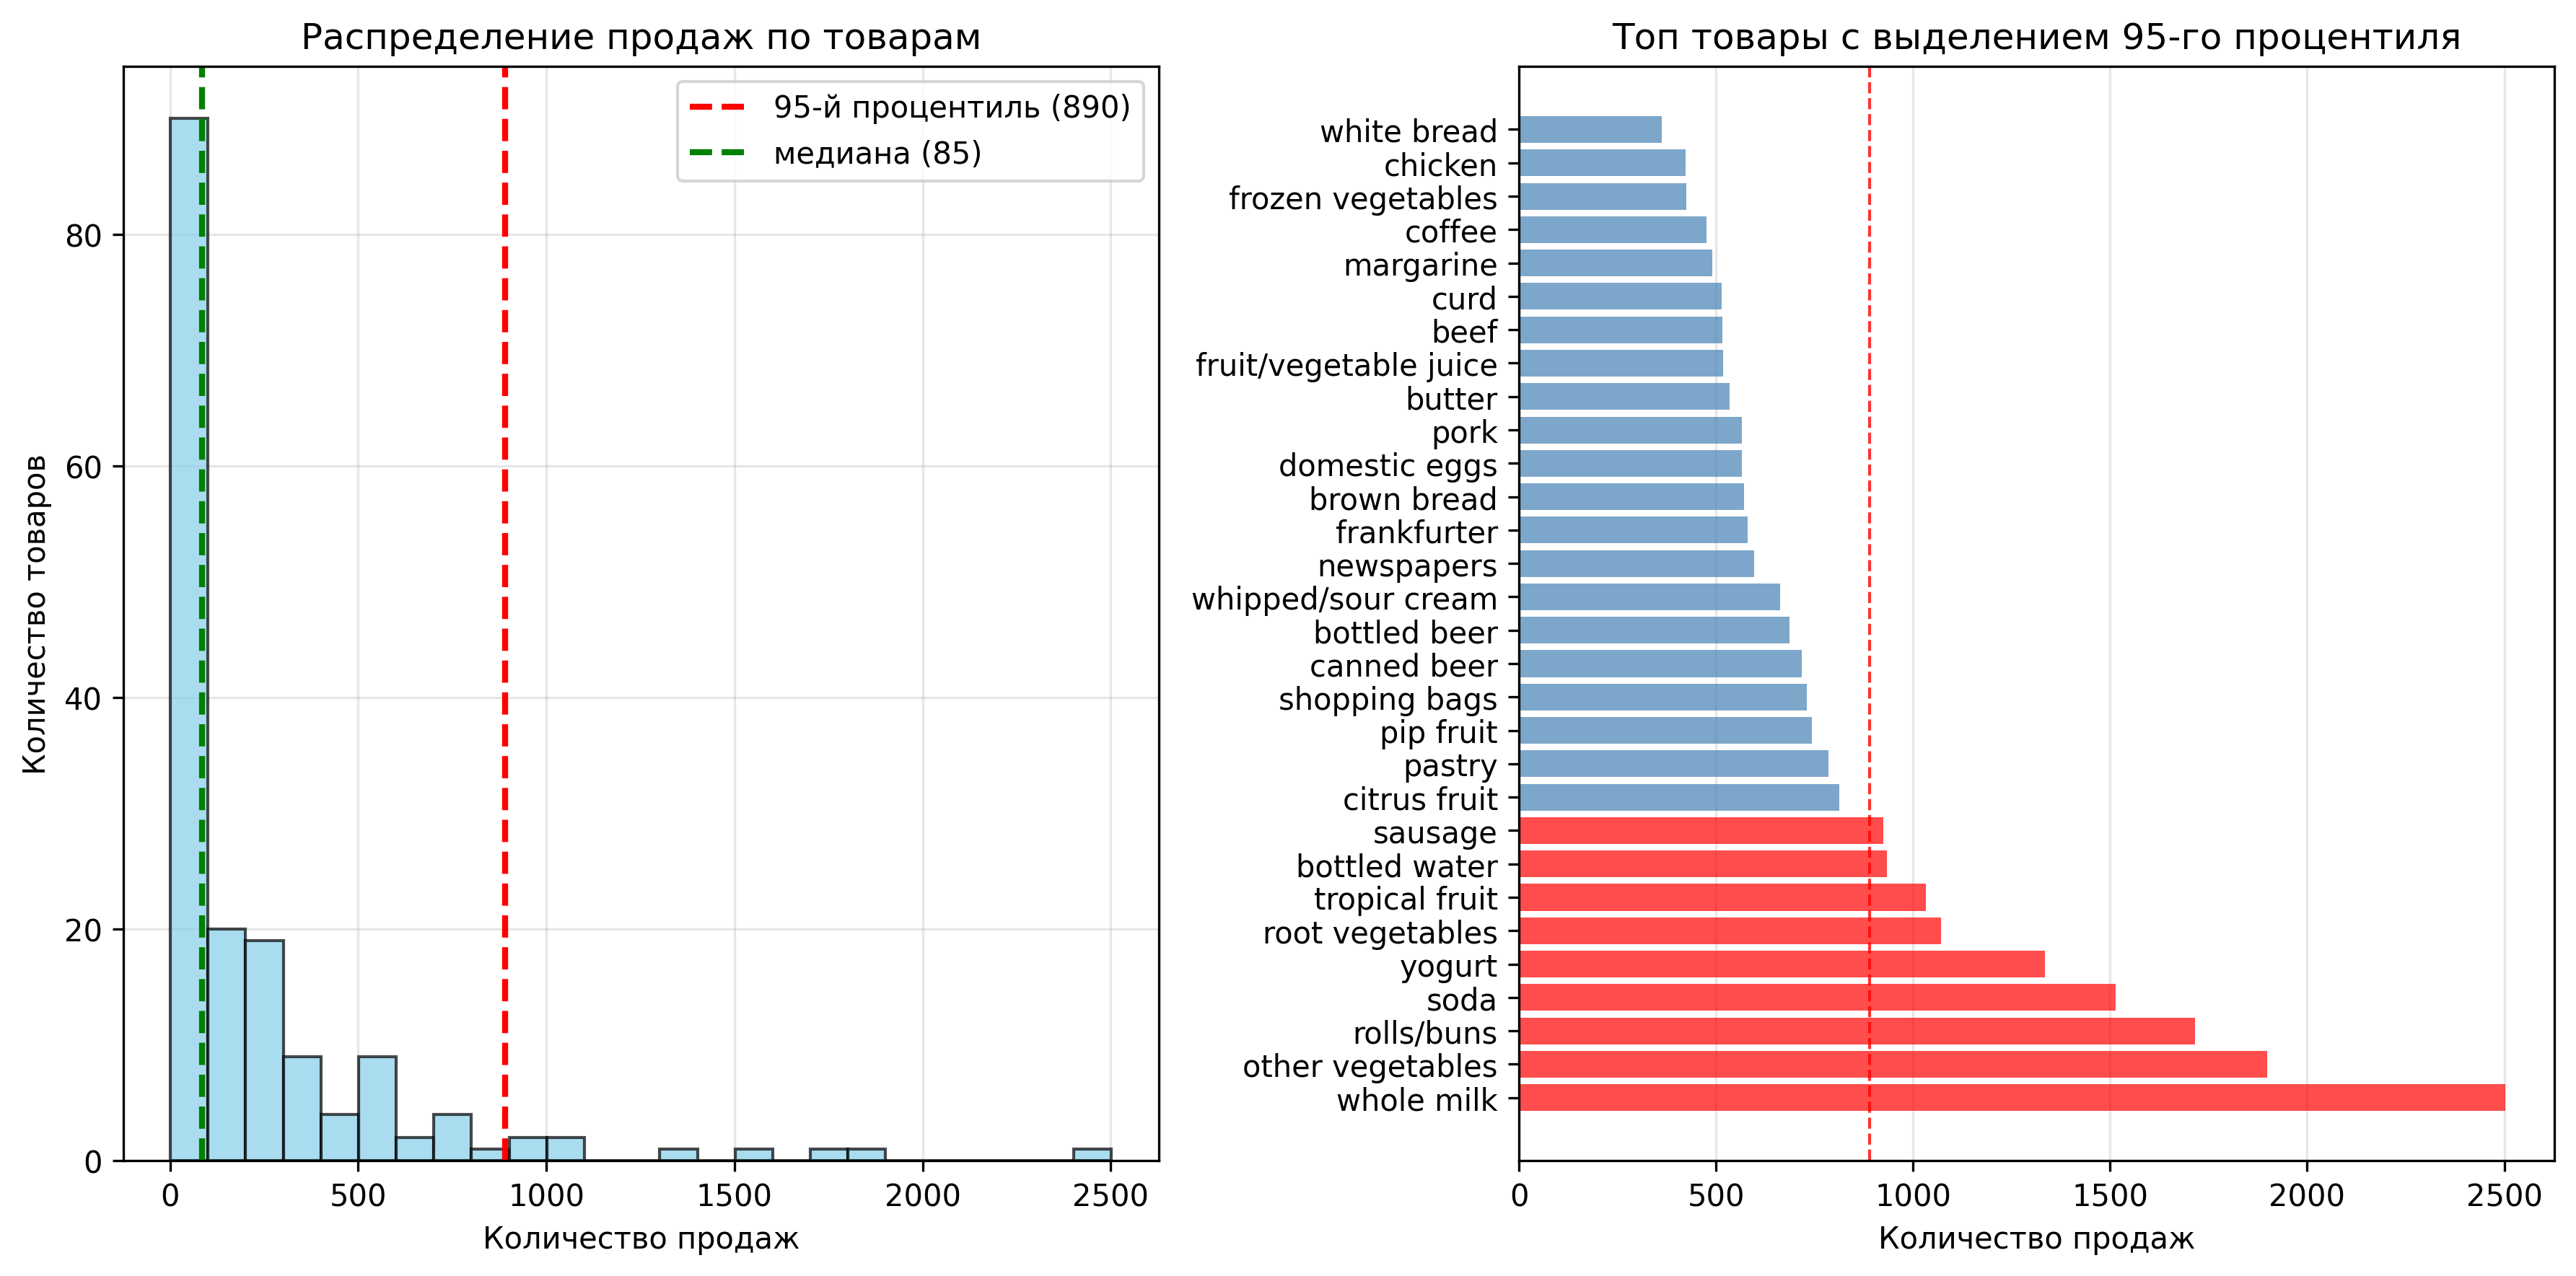

Процент продаж топ-5% товаров: 33.34%
Процент продаж товаров ниже медианы: 7.43%


In [7]:
item_sales = df.groupby('itemDescription', as_index=False).size()
item_sales = item_sales.rename(columns={'size': 'sales_count'})

item_sales = item_sales.sort_values('sales_count', ascending=False)

percentile_95 = np.percentile(item_sales['sales_count'], 95)
print(f"95-й процентиль продаж: {percentile_95:.0f}")
print(f"Медиана продаж: {item_sales['sales_count'].median()}")
print(f"Коэффициент вариации: {(item_sales['sales_count'].std() / item_sales['sales_count'].mean() * 100):.1f}%")

high_demand_items = item_sales[item_sales['sales_count'] > percentile_95]
plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)

plt.hist(item_sales['sales_count'], bins=25, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(percentile_95, color='red', linestyle='--', linewidth=2, 
           label=f'95-й процентиль ({percentile_95:.0f})')
plt.axvline(item_sales['sales_count'].median(), color='green', linestyle='--', linewidth=2, 
           label=f'медиана ({item_sales['sales_count'].median():.0f})')
plt.xlabel('Количество продаж')
plt.ylabel('Количество товаров')
plt.title('Распределение продаж по товарам')
plt.legend()

plt.grid(True, which='major', alpha=0.3)
plt.grid(True, which='minor', alpha=0.1)

plt.gca().set_axisbelow(True)

plt.subplot(1, 2, 2)
top_items = item_sales.head(30)

colors = ['red' if x > percentile_95 else 'steelblue' for x in top_items['sales_count']]

plt.barh(top_items['itemDescription'], top_items['sales_count'], color=colors, alpha=0.7)
plt.axvline(percentile_95, color='red', linestyle='--', linewidth=1, alpha=0.8)
plt.xlabel('Количество продаж')
plt.title('Топ товары с выделением 95-го процентиля')

plt.grid(True, axis='x', which='major', alpha=0.3)

plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.show()

top_5_percent = top_items[top_items['sales_count'] > percentile_95].sum()
all_sales = item_sales['sales_count'].sum()
concentration_ratio = top_5_percent['sales_count'] / all_sales * 100
print(f"Процент продаж топ-5% товаров: {concentration_ratio:.2f}%")

bottom_sales = item_sales[item_sales['sales_count'] < 85].sum()
concentration_ratio = bottom_sales['sales_count'] / all_sales * 100
print(f"Процент продаж товаров ниже медианы: {concentration_ratio:.2f}%")

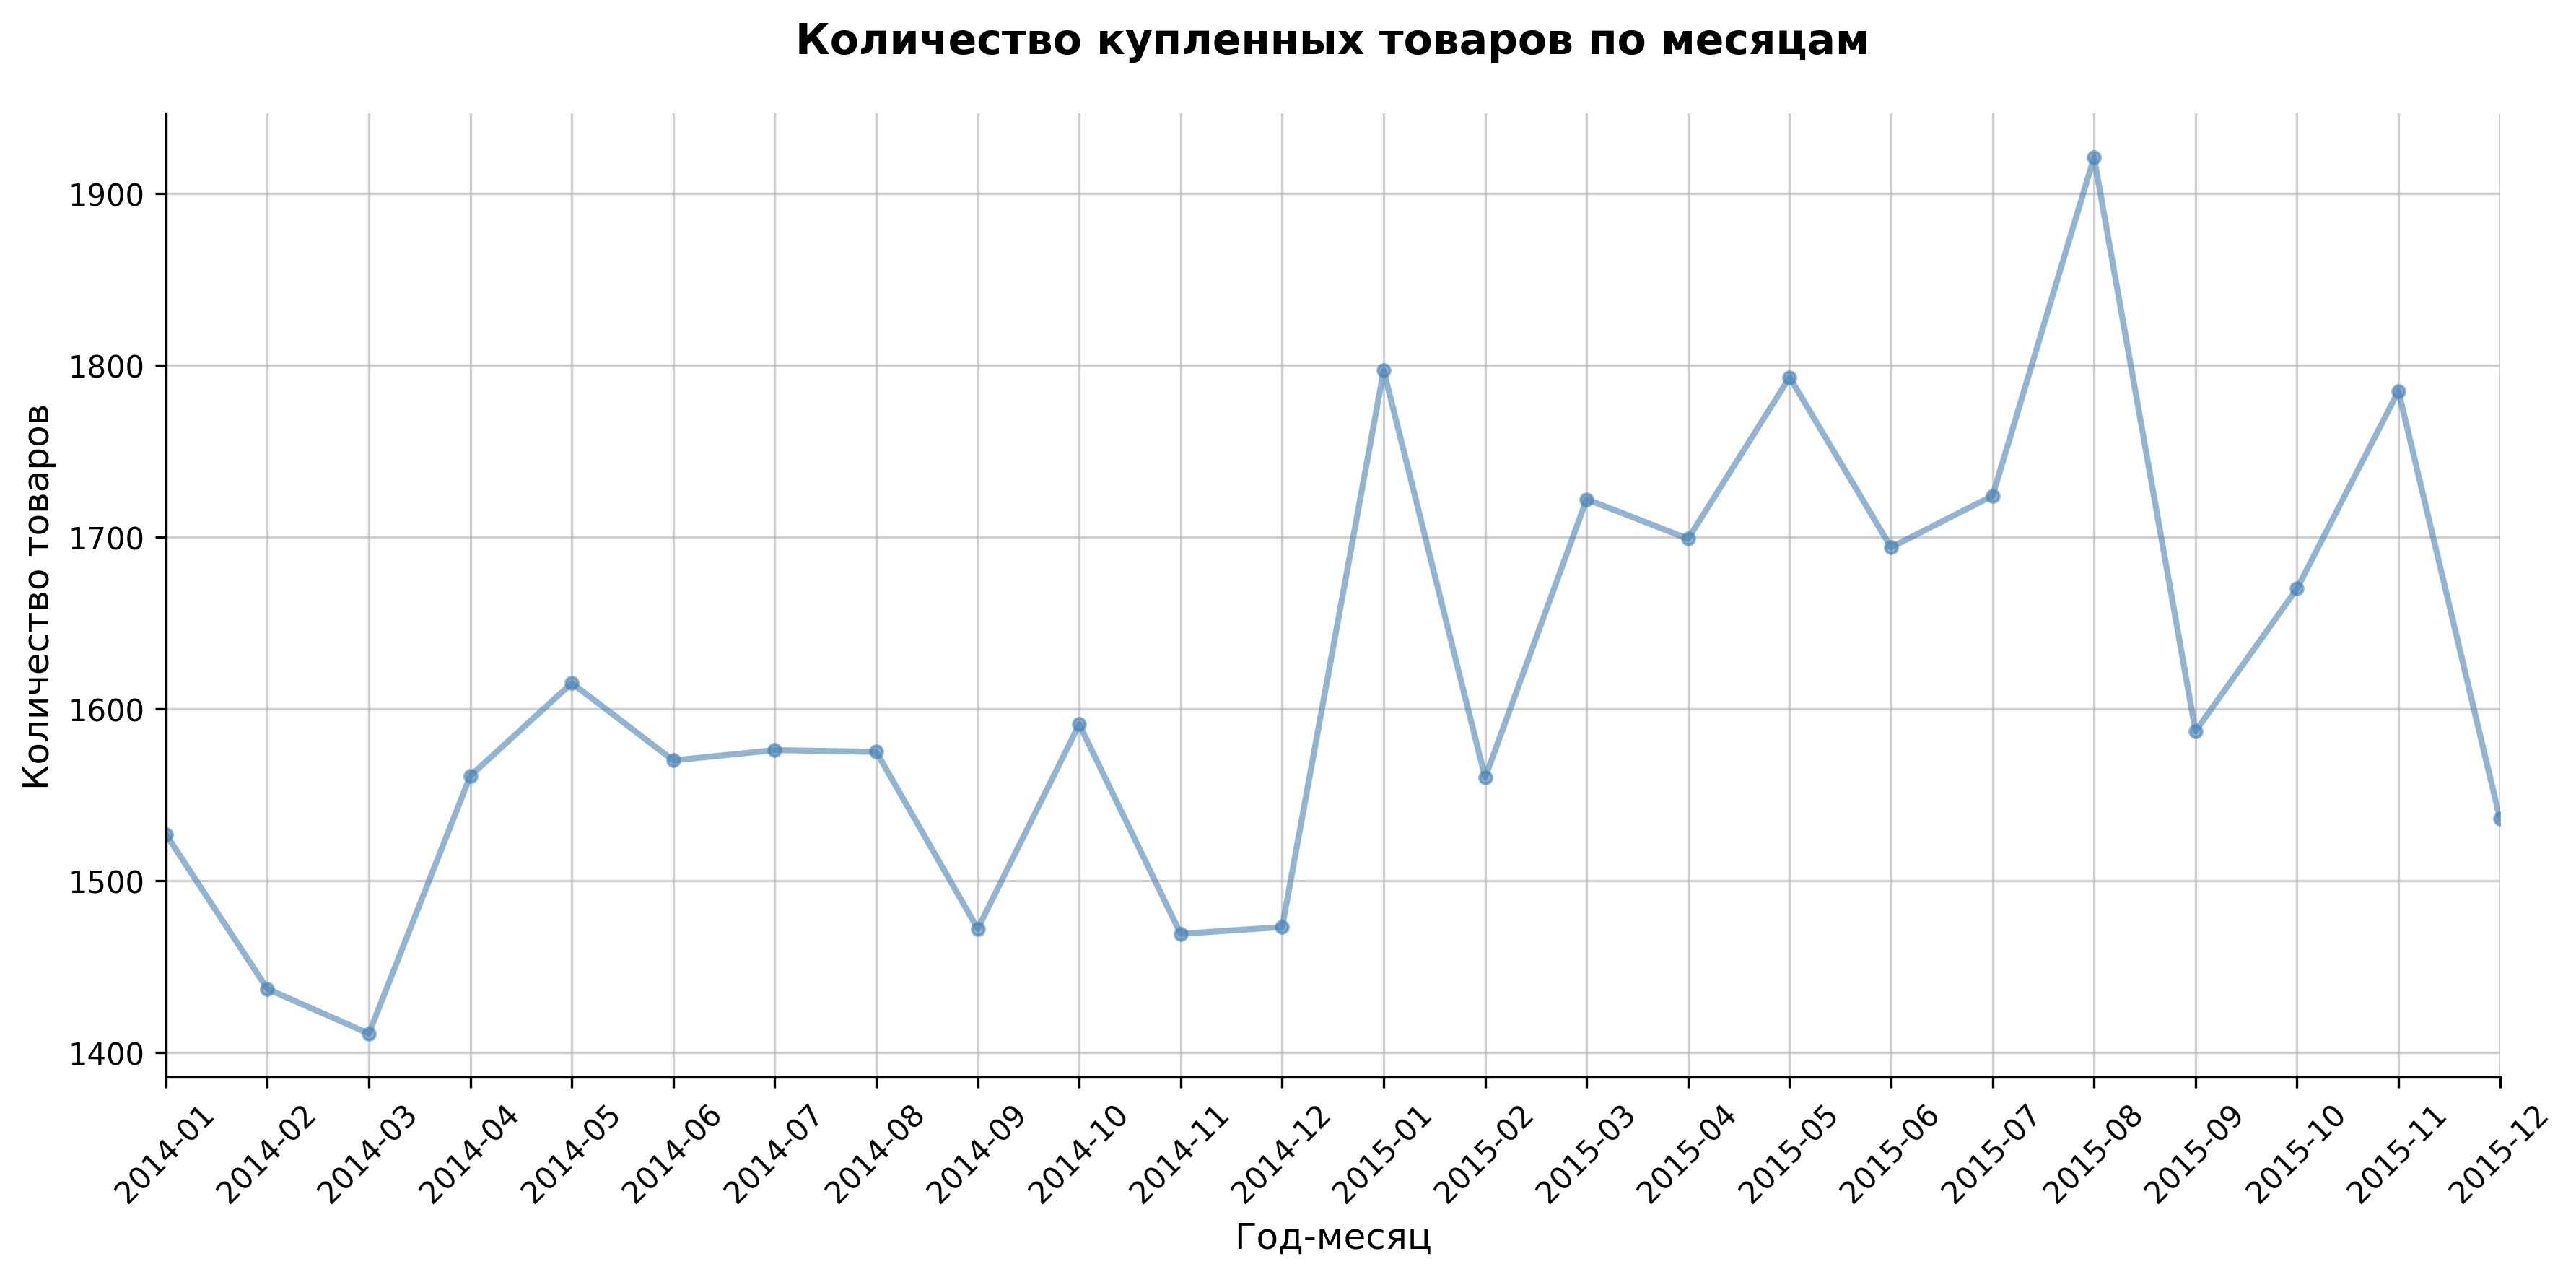

In [8]:
data1 = df.copy()
data1.index = data1.Date

monthly_data = data1.resample('ME')['itemDescription'].count()

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

monthly_data.plot(
    ax=ax,
    linewidth=2,
    marker='o',
    markersize=4,
    color='steelblue',
    alpha=0.6
)

ax.set_xticks(monthly_data.index)
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

ax.set_title('Количество купленных товаров по месяцам', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Год-месяц', fontsize=12)
ax.set_ylabel('Количество товаров', fontsize=12)
ax.grid(True, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

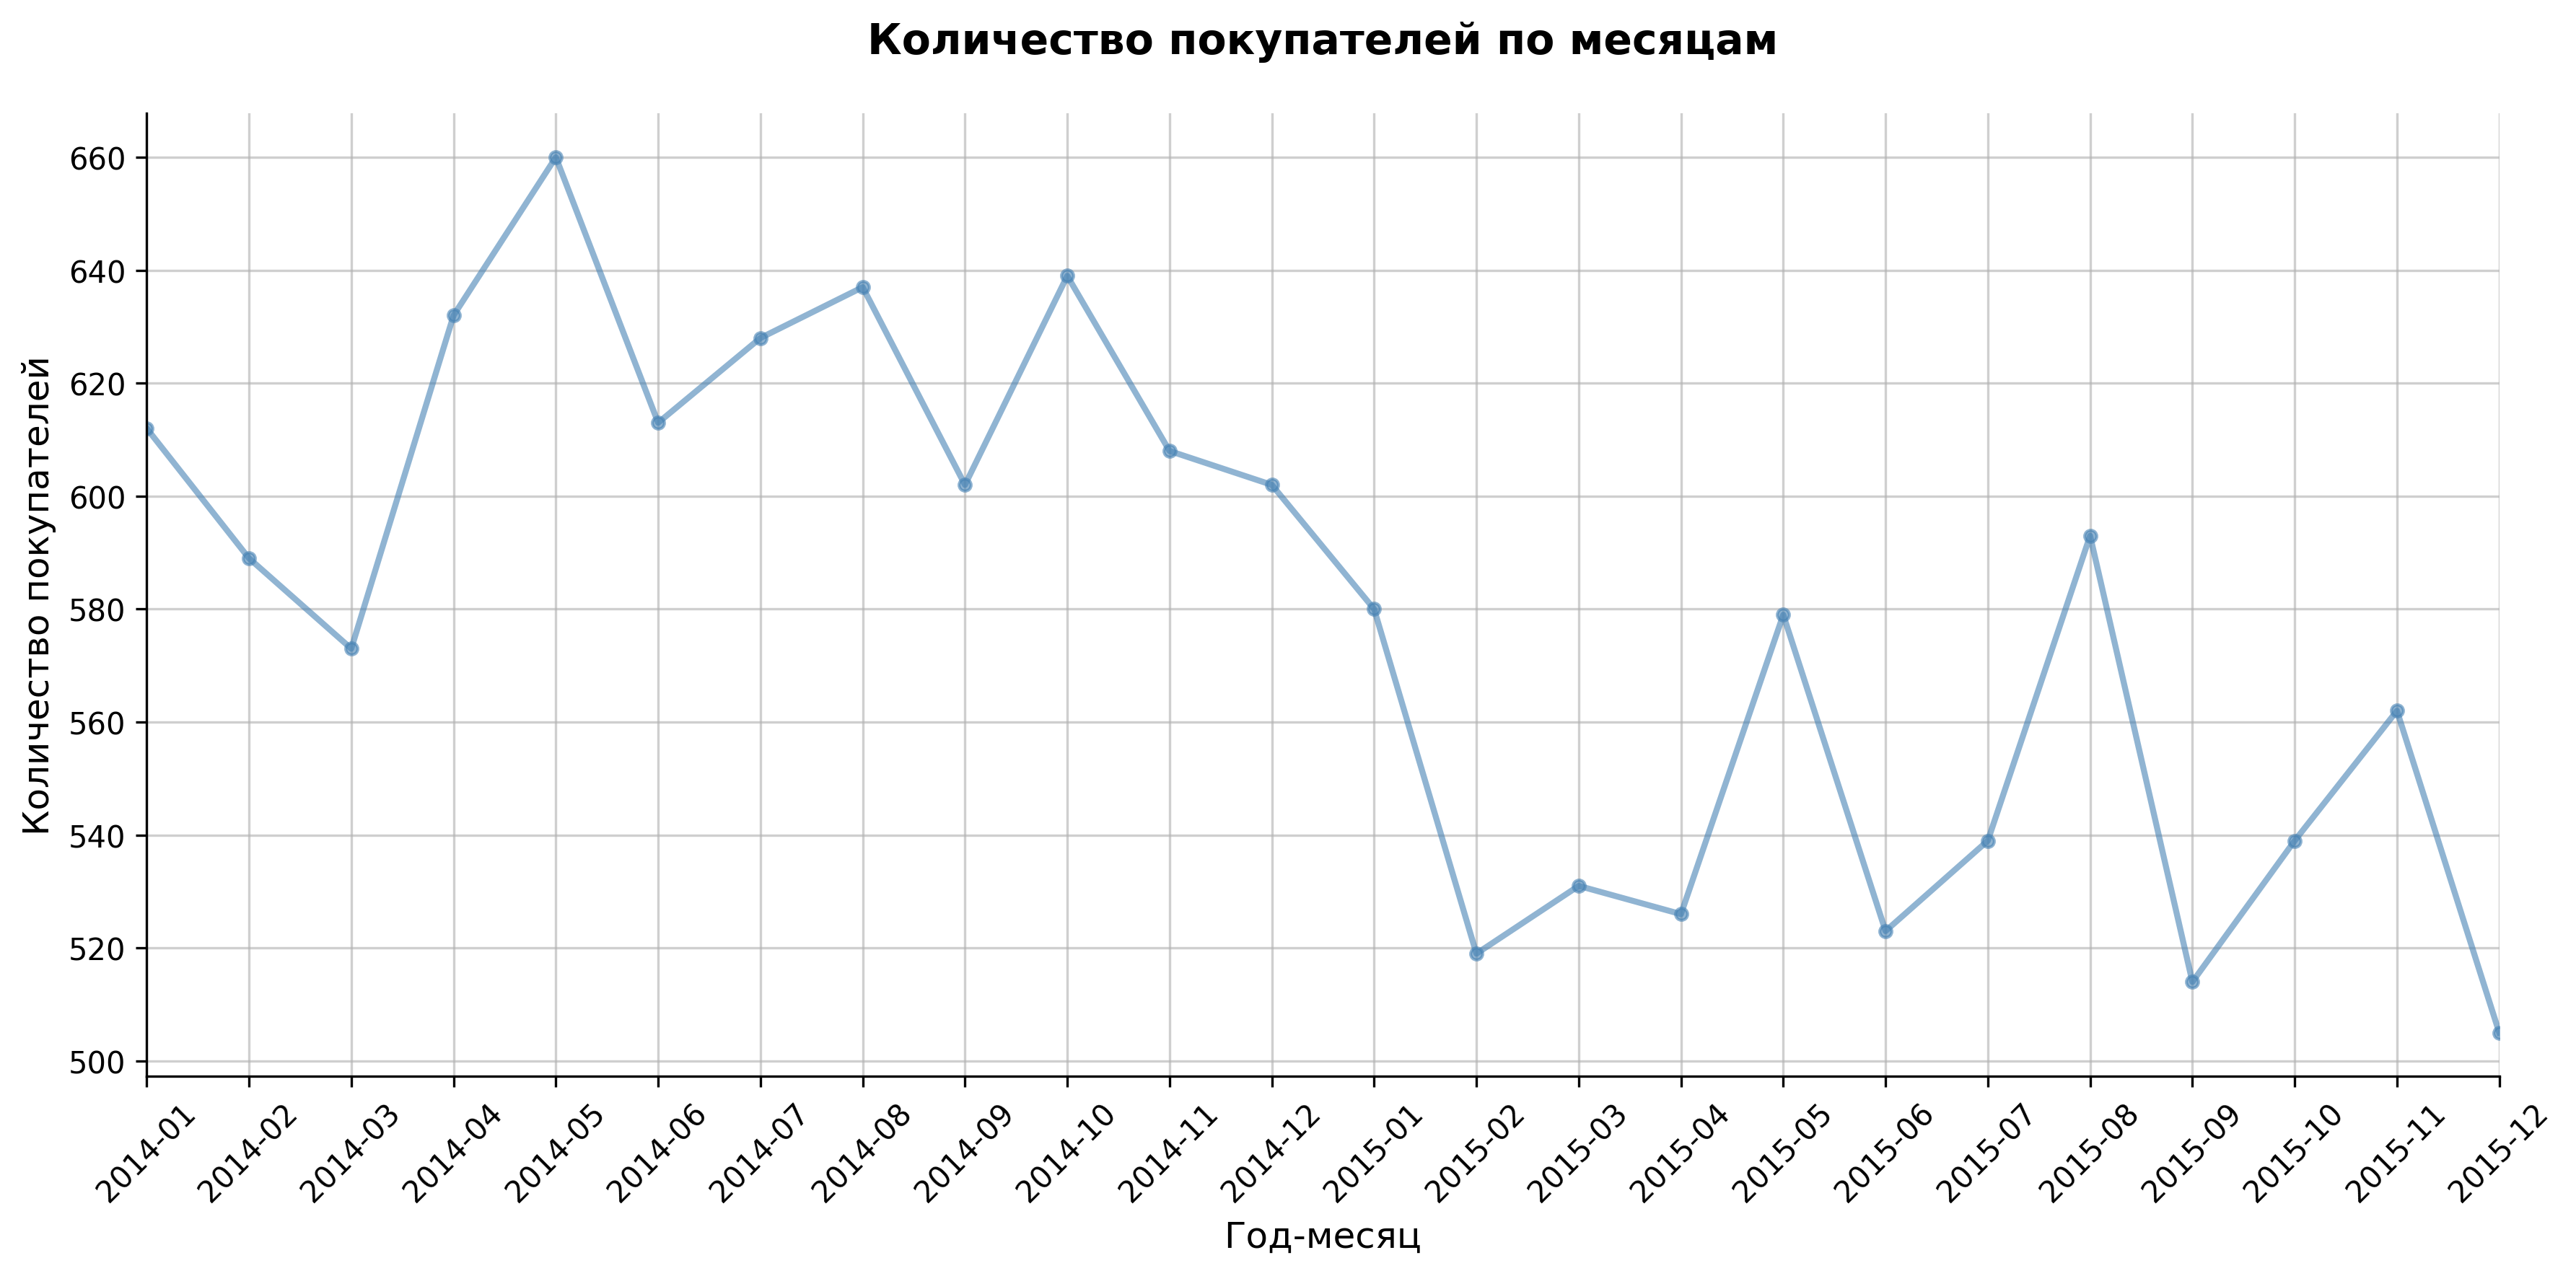

In [9]:
data = df.copy()
data.index = data['Date']

monthly_data = data.resample('ME')[['Member_number']].nunique()

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

monthly_data.plot(
    ax=ax,
    linewidth=2,
    marker='o',
    markersize=4,
    color='steelblue',
    alpha=0.6,
    legend=False
)

ax.set_xticks(monthly_data.index)
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

ax.set_title('Количество покупателей по месяцам', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Год-месяц', fontsize=12)
ax.set_ylabel('Количество покупателей', fontsize=12)
ax.grid(True, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

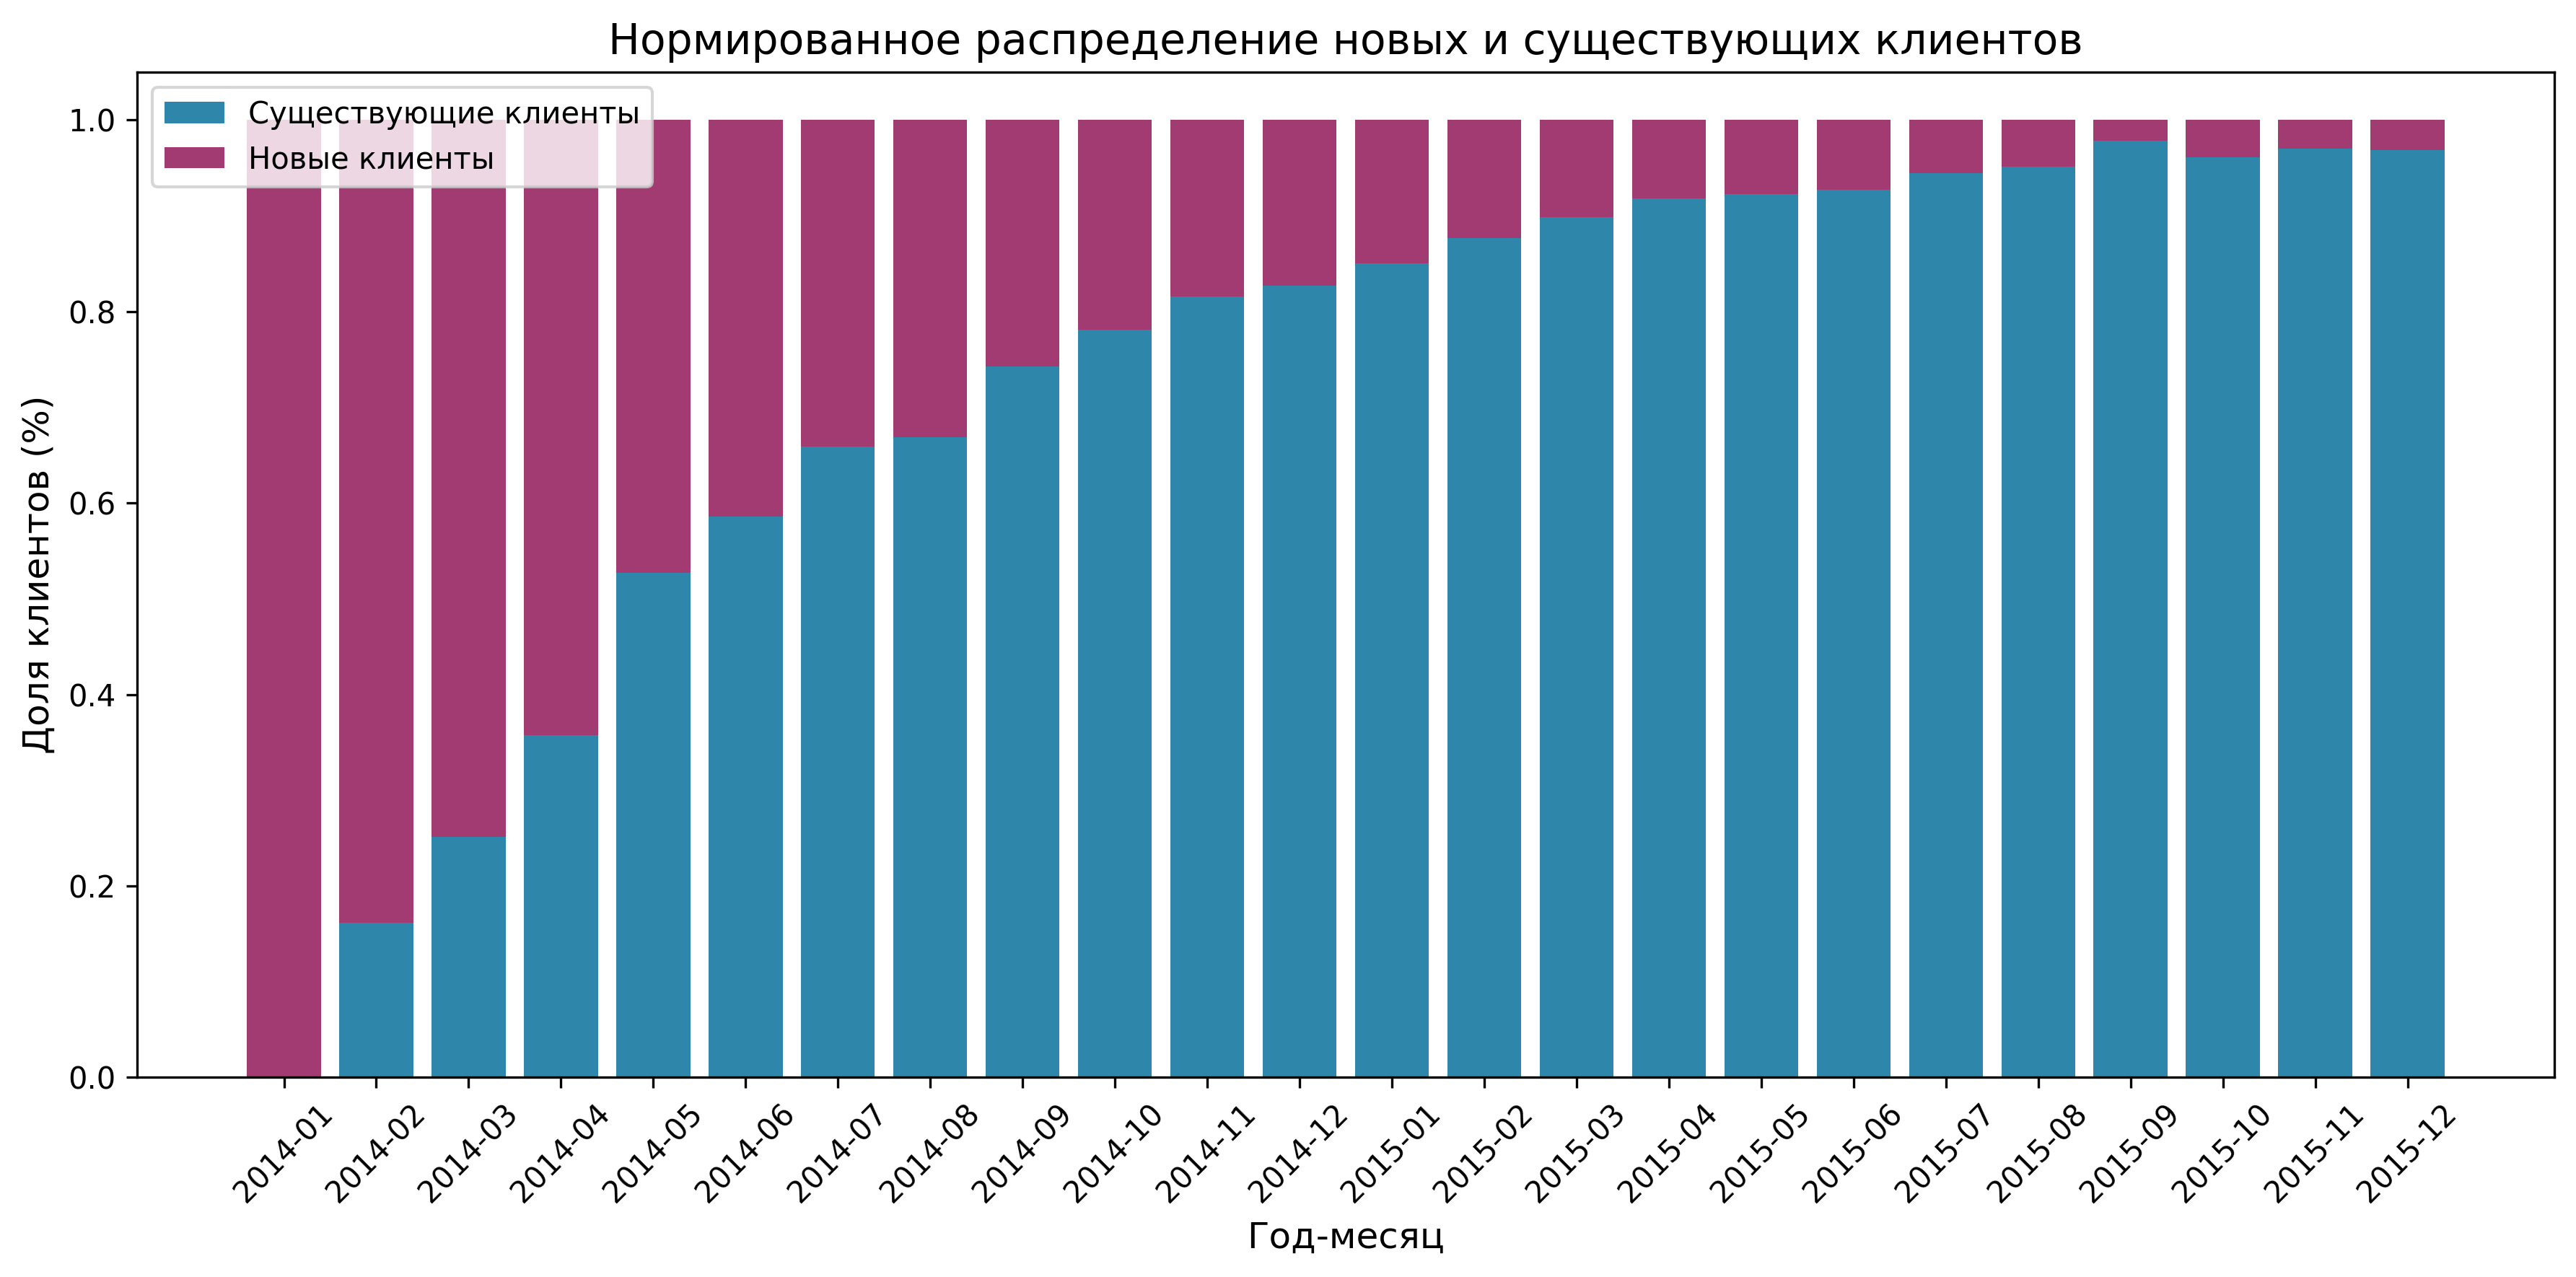

In [10]:
monthly_data = monthly_data.reset_index().rename(columns={'Member_number': 'old_customers_count'})
monthly_data['year_month'] = monthly_data['Date'].dt.strftime('%Y-%m')

new_customers_monthly = df.groupby('Member_number')['Date'].min().dt.strftime('%Y-%m').value_counts().sort_index().reset_index() \
    .rename(columns={'Date': 'year_month', 'count': 'new_customers_count'})

df_combined = pd.merge(monthly_data, new_customers_monthly, on='year_month')
df_combined['new_customers_count_pct'] = df_combined['new_customers_count'] / df_combined['old_customers_count']
df_combined['old_customers_count_pct'] = 1 - df_combined['new_customers_count_pct']

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

bars1 = ax.bar(df_combined['year_month'], df_combined['old_customers_count_pct'], 
               label='Существующие клиенты', color='#2E86AB')
bars2 = ax.bar(df_combined['year_month'], df_combined['new_customers_count_pct'], 
               bottom=df_combined['old_customers_count_pct'], 
               label='Новые клиенты', color='#A23B72')

ax.set_ylabel('Доля клиентов (%)', fontsize=12)
ax.set_xlabel('Год-месяц', fontsize=12)
ax.set_title('Нормированное распределение новых и существующих клиентов', fontsize=14)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

__Когортный анализ.__

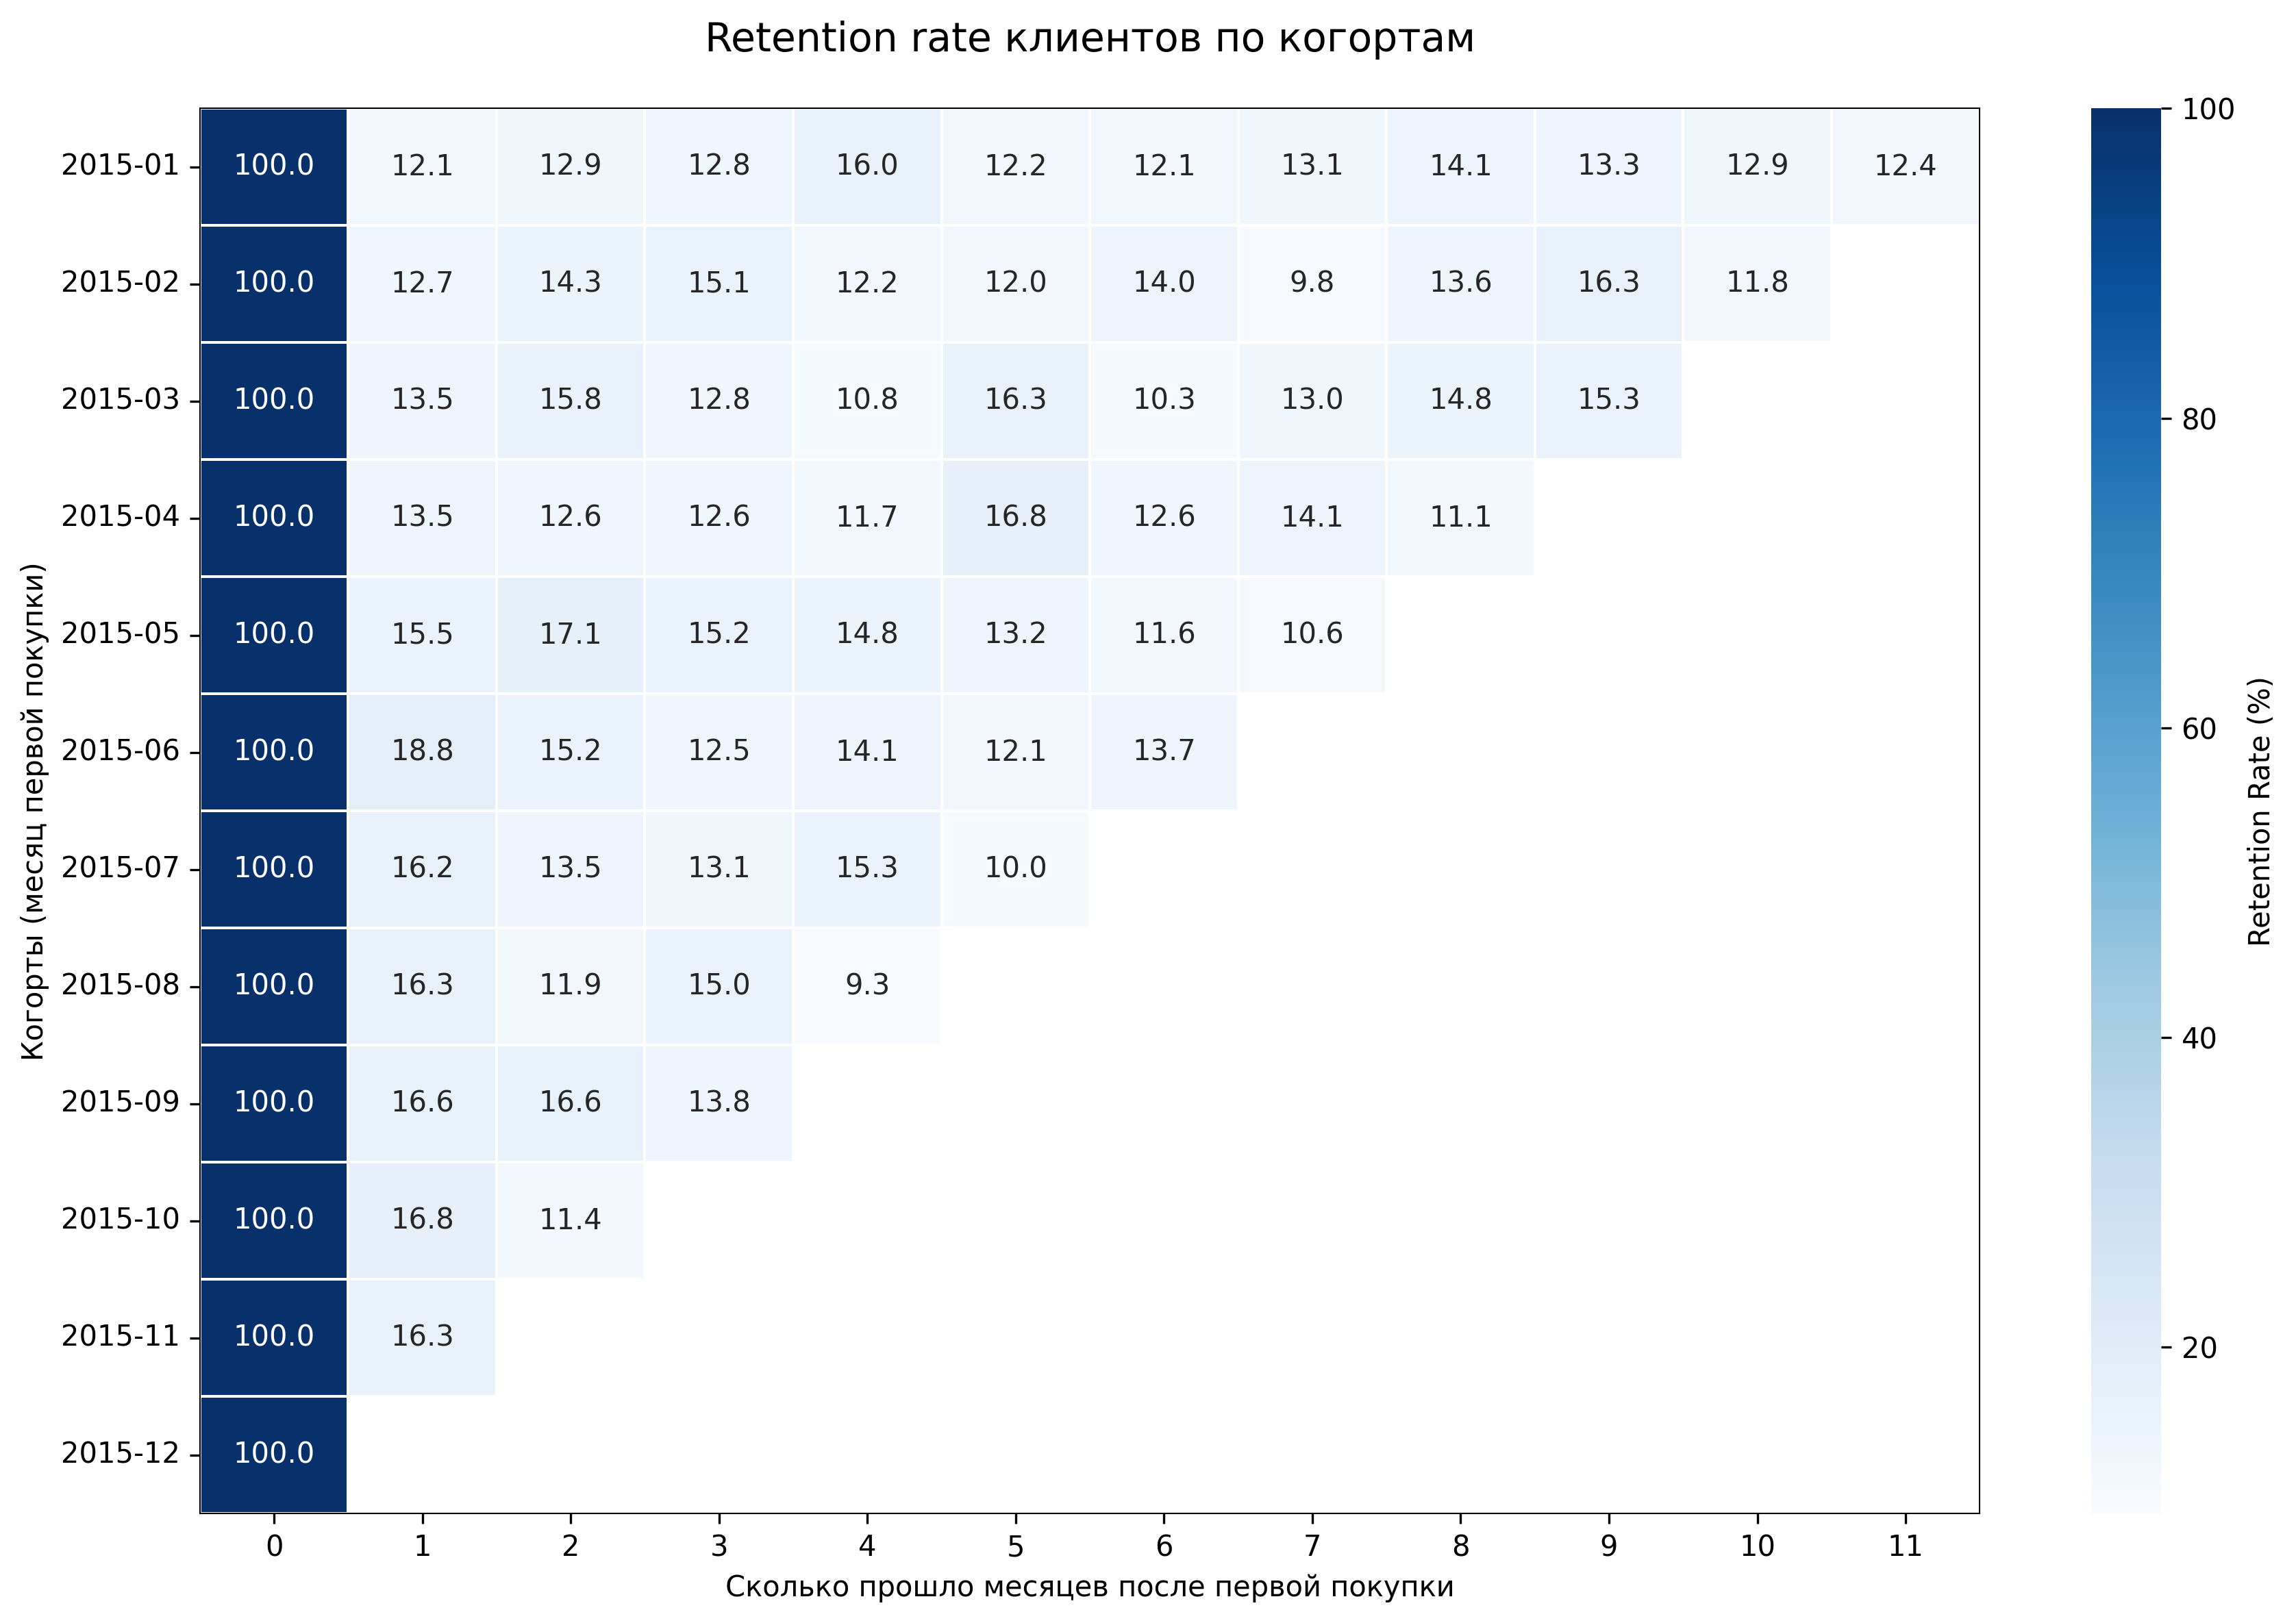

In [11]:
data = df.copy()
data = data.query('Date.dt.year == 2015')
data['OrderMonth'] = data['Date'].dt.to_period('M')
data['Cohort'] = data.groupby('Member_number')['Date'].transform('min').dt.to_period('M')

data['Period'] = (data['OrderMonth'] - data['Cohort']).apply(lambda x: x.n)

cohort_data = data.groupby(['Cohort', 'Period'])['Member_number'].nunique().reset_index()
cohort_data1 = data.groupby('Cohort')['Member_number'].nunique().reset_index()
cohort_pivot = cohort_data.pivot_table(index='Cohort', columns='Period', values='Member_number')

cohort_sizes = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0) * 100

cohort_pivot

plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(
    retention_matrix, 
    annot=True, 
    fmt='.1f', 
    cmap='Blues',
    cbar_kws={'label': 'Retention Rate (%)'},
    linewidths=0.5
)

plt.title('Retention rate клиентов по когортам', fontsize=14, pad=20)
plt.ylabel('Когорты (месяц первой покупки)')
plt.xlabel('Сколько прошло месяцев после первой покупки')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

for _, spine in plt.gca().spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

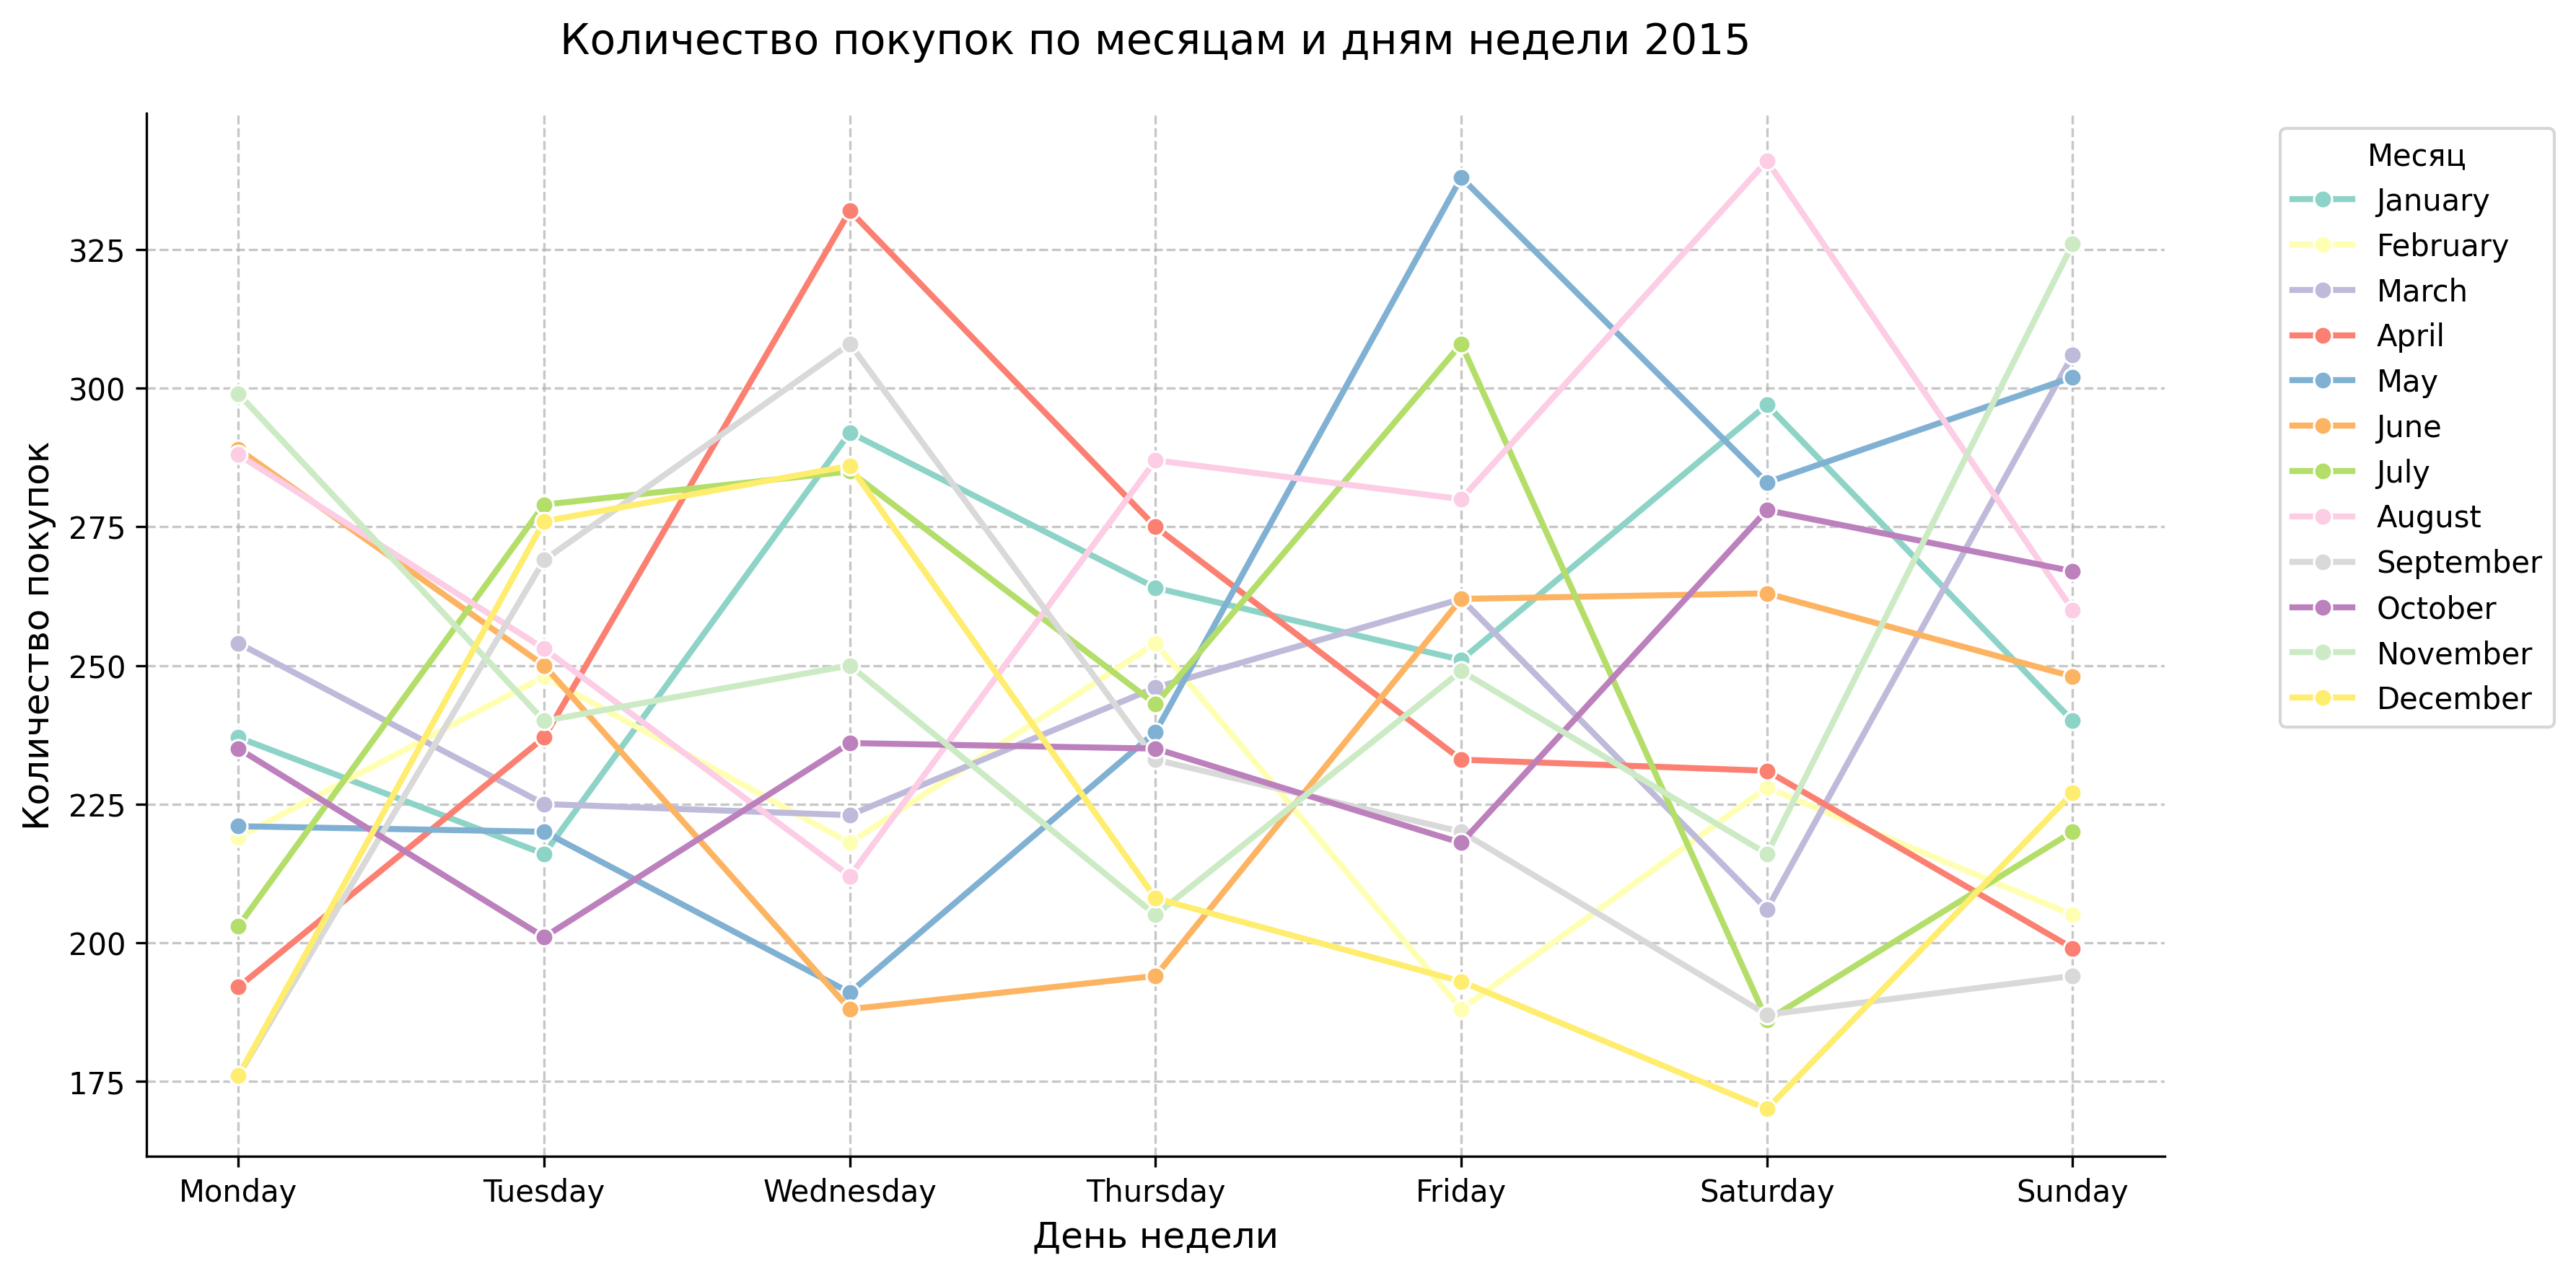

In [12]:
data = df.query("Date.dt.year == 2015").copy()
data['day_of_week'] = data['Date'].dt.day_name()
data['month'] = data['Date'].dt.month_name()

data1 = data.groupby(['month', 'day_of_week'], as_index=False)[['itemDescription']].count().rename(columns={'itemDescription': 'purchase_count'})

months_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data1['month'] = pd.Categorical(data1['month'], categories=months_ordered, ordered=True)
data1['day_of_week'] = pd.Categorical(data1['day_of_week'], categories=days_ordered, ordered=True)
data1 = data1.sort_values(['month', 'day_of_week'])


plt.figure(figsize=(12, 6), dpi=300) 
ax = sns.lineplot(
    data=data1, 
    x='day_of_week', 
    y='purchase_count',
    hue='month',
    marker='o',
    linewidth=2,
    markersize=6,
    palette='Set3'
)

plt.title('Количество покупок по месяцам и дням недели 2015', fontsize=14, pad=20)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество покупок', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(title='Месяц', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

__Сформулируем и проверим такую бизнес-гипотезу: 
    "Покупатели, совершающие первую покупку в выходные дни, имеют более высокий LTV, чем те, кто пришел в будни"__

Профит, который может получить бизнес, если гипотеза подтвердится:
    1. Оптимизация маркетингового бюджета (смещение его на выходные);
    2. Увеличение пожизненной ценности клиента (дополнительная ценность, если привлекать новых клиентов в выходные);
    3. Операционная эффективность: оптимизация персонала, управление запасами;
    4. Акции и стимулирование, эксклюзивные мероприятия в выходные дни.

In [13]:
new_data = df.copy()

In [14]:
new_data['first_purchase'] = new_data.groupby('Member_number')['Date'].transform('min')
new_data['day_of_f_p'] = new_data['first_purchase'].dt.day_name()
new_data['Is_Weekday'] = new_data['day_of_f_p'].isin(['Saturday', 'Sunday'])

weekday_customers = new_data[new_data['Is_Weekday'] == True]['Member_number']
weekend_customers = new_data[new_data['Is_Weekday'] == False]['Member_number']

def calculate_customer_ltv(customer_ids):
    customer_data = df[df['Member_number'].isin(customer_ids)]
    
    ltv_metrics = {
        'avg_transactions_per_customer': customer_data.groupby('Member_number')['Date'].nunique().mean(),
        'avg_items_per_customer': customer_data.groupby('Member_number').size().mean(),
        'median_transactions_per_customer': customer_data.groupby('Member_number')['Date'].nunique().median(),
        'median_items_per_customer': customer_data.groupby('Member_number').size().median(),
    }
    return ltv_metrics

weekend_ltv = print(f"Клиенты с первой покупкой в будний день: {calculate_customer_ltv(weekend_customers)}")
weekday_ltv = print(f"Клиенты с первой покупкой в выходной день: {calculate_customer_ltv(weekday_customers)}")

Клиенты с первой покупкой в будний день: {'avg_transactions_per_customer': np.float64(3.865740740740741), 'avg_items_per_customer': np.float64(9.991096866096866), 'median_transactions_per_customer': np.float64(4.0), 'median_items_per_customer': np.float64(9.0)}
Клиенты с первой покупкой в выходной день: {'avg_transactions_per_customer': np.float64(3.768807339449541), 'avg_items_per_customer': np.float64(9.825688073394495), 'median_transactions_per_customer': np.float64(4.0), 'median_items_per_customer': np.float64(9.0)}


**Перейдем к анализу рыночной корзины (Market Basket Analysis) / Association Rules.**

In [15]:
import re
await micropip.install('mlxtend')
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

In [16]:
basket = df.copy()

/lib/python3.12/site-packages/pyodide_kernel/kernel.py:114: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  if self.interpreter.should_run_async(code):


In [17]:
basket.itemDescription = basket.itemDescription.transform(lambda x: [x])
basket = basket.groupby(['Member_number','Date']).sum()['itemDescription'].reset_index(drop=True)

encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)

frequent_itemsets = apriori(transactions, min_support= 6/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5)
display(rules.head())
print("Rules identified: ", len(rules))

/lib/python3.12/site-packages/pyodide_kernel/kernel.py:114: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  if self.interpreter.should_run_async(code):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(UHT-milk),(butter milk),0.021386,0.017577,0.000601,0.028125,1.600131,1.0,0.000226,1.010854,0.383247,0.015679,0.010737,0.031173
1,(butter milk),(UHT-milk),0.017577,0.021386,0.000601,0.034221,1.600131,1.0,0.000226,1.013289,0.381761,0.015679,0.013115,0.031173
2,(UHT-milk),(cream cheese ),0.021386,0.023658,0.000869,0.040625,1.717152,1.0,0.000363,1.017685,0.426767,0.019667,0.017378,0.038674
3,(cream cheese ),(UHT-milk),0.023658,0.021386,0.000869,0.036723,1.717152,1.0,0.000363,1.015922,0.427761,0.019667,0.015672,0.038674
4,(soda),(artif. sweetener),0.097106,0.001938,0.000468,0.004818,2.485725,1.0,0.000280,1.002893,0.661986,0.004746,0.002885,0.123098


Rules identified:  190


In [18]:
rules['pair_key'] = rules.apply(
    lambda x: tuple(sorted(list(x['antecedents']) + list(x['consequents']))), 
    axis=1
)

final_unique_rules = (rules
                     .sort_values('lift', ascending=False)
                     .groupby('pair_key')
                     .first()
                     .reset_index()
                     .drop('pair_key', axis=1))

top_10_final = final_unique_rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
display(top_10_final)

/lib/python3.12/site-packages/pyodide_kernel/kernel.py:114: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  if self.interpreter.should_run_async(code):


,antecedents,consequents,support,confidence,lift
61,(liver loaf),(fruit/vegetable juice),0.000401,0.120000,3.527623
63,(pickled vegetables),(ham),0.000535,0.059701,3.489506
92,(sugar),(spread cheese),0.000401,0.022642,3.387849
70,(herbs),(oil),0.000468,0.044304,2.972725
66,(soft cheese),(hamburger meat),0.000601,0.060000,2.745505
68,(hard cheese),(soft cheese),0.000401,0.027273,2.720545
65,(hamburger meat),(pasta),0.000468,0.021407,2.647181
26,(canned beer),(liver loaf),0.000401,0.008547,2.557778
37,(frozen fish),(chocolate),0.000401,0.058824,2.493418
2,(soda),(artif. sweetener),0.000468,0.004818,2.485725


In [19]:
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]
milk_rules = milk_rules.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)

display(milk_rules.head())

/lib/python3.12/site-packages/pyodide_kernel/kernel.py:114: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  if self.interpreter.should_run_async(code):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,pair_key
0,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,1.0,0.000468,1.279957,0.539750,0.005444,0.218724,0.173803,"(brandy, whole milk)"
1,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,1.0,0.000369,1.190523,0.461695,0.005017,0.160033,0.148881,"(softener, whole milk)"
2,(canned fruit),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,1.0,0.000179,1.178908,0.447899,0.002523,0.151757,0.144127,"(canned fruit, whole milk)"
3,(syrup),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,1.0,0.000179,1.178908,0.447899,0.002523,0.151757,0.144127,"(syrup, whole milk)"
4,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,1.0,0.000229,1.162868,0.428360,0.003356,0.140057,0.139624,"(artif. sweetener, whole milk)"


In [21]:
new_frequent_itemsets = apriori(transactions, min_support= 8/len(basket), use_colnames=True, max_len = 3)
new_rules = association_rules(new_frequent_itemsets, metric="lift",  min_threshold = 1.5)

new_rules = new_rules.sort_values(by='confidence', ascending=False)
new_rules[new_rules['antecedents'].apply(len) > 1].head(15)

/lib/python3.12/site-packages/pyodide_kernel/kernel.py:114: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  if self.interpreter.should_run_async(code):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
126,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,1.0,0.000359,1.383412,0.597337,0.003786,0.277150,0.197557
147,"(white bread, rolls/buns)",(whole milk),0.002139,0.157923,0.000601,0.281250,1.780933,1.0,0.000264,1.171586,0.439436,0.003772,0.146456,0.142529
101,"(shopping bags, sausage)",(other vegetables),0.001938,0.122101,0.000535,0.275862,2.259291,1.0,0.000298,1.212336,0.558466,0.004329,0.175146,0.140120
162,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,1.0,0.000563,1.131541,0.384877,0.009065,0.116250,0.132562
141,"(rolls/buns, whipped/sour cream)",(yogurt),0.002941,0.085879,0.000601,0.204545,2.381800,1.0,0.000349,1.149181,0.581861,0.006818,0.129815,0.105775
142,"(yogurt, whipped/sour cream)",(rolls/buns),0.002941,0.110005,0.000601,0.204545,1.859425,1.0,0.000278,1.118851,0.463562,0.005354,0.106226,0.105007
107,"(tropical fruit, sausage)",(other vegetables),0.003074,0.122101,0.000601,0.195652,1.602377,1.0,0.000226,1.091442,0.377087,0.004828,0.083781,0.100289
133,"(tropical fruit, sausage)",(rolls/buns),0.003074,0.110005,0.000601,0.195652,1.778580,1.0,0.000263,1.106481,0.439104,0.005348,0.096234,0.100560
146,"(white bread, whole milk)",(rolls/buns),0.003141,0.110005,0.000601,0.191489,1.740738,1.0,0.000256,1.100784,0.426872,0.005344,0.091556,0.098479
153,"(sausage, root vegetables)",(soda),0.003342,0.097106,0.000601,0.180000,1.853641,1.0,0.000277,1.101090,0.462065,0.006024,0.091809,0.093097
